# Project Lung DAPI

Import library

In [107]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.color import rgb2hed, hed2rgb
from skimage import filters, morphology, measure, segmentation, color, feature
from skimage.io import imread, imshow
from skimage.segmentation import watershed, find_boundaries
from skimage.feature import peak_local_max
from skimage.measure import regionprops, find_contours
from skimage.exposure import equalize_adapthist
from skimage.segmentation import mark_boundaries
from skimage.morphology import white_tophat
from skimage.util import crop
from skimage.draw import polygon
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
import xml.etree.ElementTree as ET
import cv2
import json
import geojson

Load DAPI path

In [2]:
# Specify the path to your qptiff file
cod_path = "D016-RLL-11B2-6_Scan3.qptiff"

## Small cropped DAPI 

Cropped DAPI

In [13]:
with tifffile.TiffFile(cod_path) as tif:
    dapi = tif.pages[0].asarray()
# plt.imshow(dapi,cmap='gray')

def parse_json_features(json_data):
    nuclei_annotations = []
    for feature in json_data['features']:
        if feature['geometry']['type'] == 'Polygon':
            vertices = feature['geometry']['coordinates'][0]  # First ring
            vertices = [(int(coord[0]), int(coord[1])) for coord in vertices]  # Assuming (x, y) format
            nuclei_annotations.append(vertices)
    return nuclei_annotations

def create_mask(image_shape, nuclei_annotations):
    mask = np.zeros(image_shape, dtype=np.uint8)
    for annotation in nuclei_annotations:
        rr, cc = polygon([v[1] for v in annotation], [v[0] for v in annotation], image_shape)
        mask[rr, cc] = 1
    return mask

# Load GeoJSON file into pandas DataFrame
json_file = 'codex_small.geojson'
json_data = pd.read_json(json_file)

# Parse JSON features
nuclei_annotations = parse_json_features(json_data)

# Get the shape of the binary mask to create the ground truth mask
image_shape = dapi.shape

# Create ground truth mask
mask_json = create_mask(image_shape, nuclei_annotations)

# Display ground truth mask from JSON
# plt.imshow(mask_json, cmap='gray')
# plt.title('Ground Truth Mask from JSON')
# plt.axis('off')
# plt.show()

In [14]:
mask_dapi = mask_json * dapi # .squeeze()

# Find the indices where the mask value is 1
roi_indices = np.where(mask_json == 1)

# Get the minimum and maximum x and y coordinates
min_x = np.min(roi_indices[1])
max_x = np.max(roi_indices[1])
min_y = np.min(roi_indices[0])
max_y = np.max(roi_indices[0])

print(min_x, max_x, min_y, max_y)

7581 7857 13180 13458


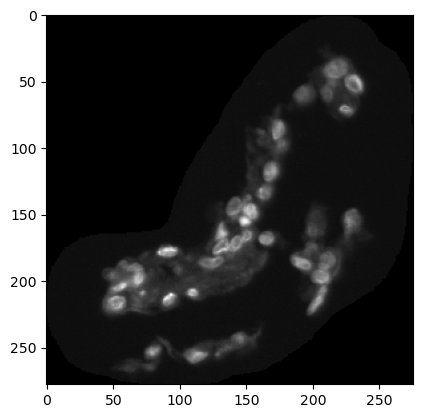

In [36]:
roi_smalldapi = mask_dapi[min_y:max_y,min_x:max_x]
plt.imshow(roi_smalldapi, 'gray')

Tophat process

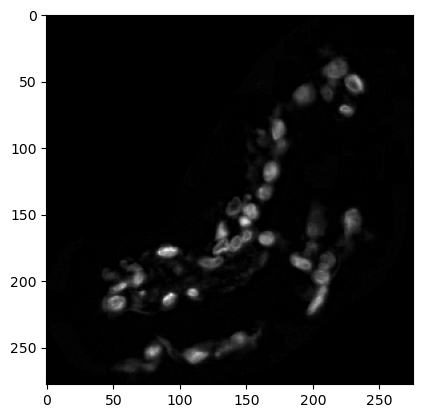

In [167]:
tophat_image = white_tophat(roi_smalldapi, footprint=np.ones((15, 15)))
plt.imshow(tophat_image,cmap='gray')

Otsu threshold

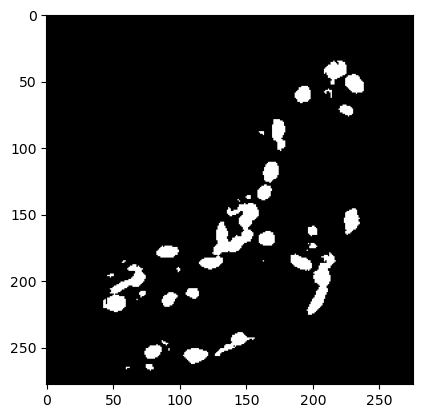

In [168]:
# Thresholding
small_thresh = filters.threshold_otsu(tophat_image)
smalldapi_binary = tophat_image > small_thresh

plt.imshow(smalldapi_binary,cmap='gray')

Morphological process

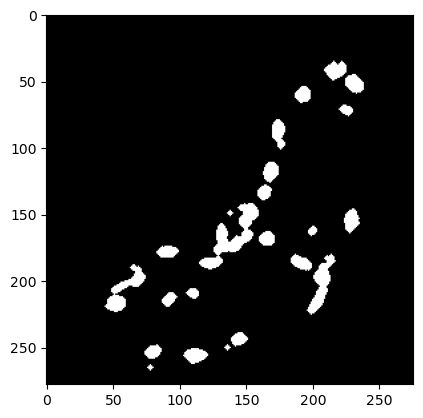

In [186]:
smalldapi_open = morphology.binary_opening(smalldapi_binary, morphology.disk(2))
plt.imshow(smalldapi_open,cmap='gray')

Watershed segmentation

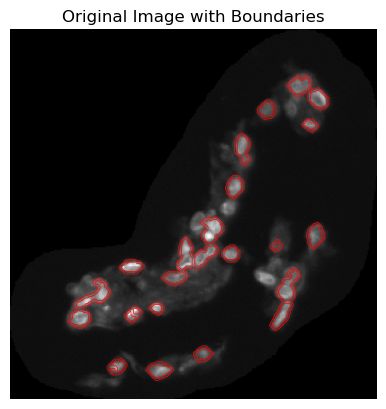

In [187]:
distance = ndi.distance_transform_edt(smalldapi_open)
coords = peak_local_max(distance, footprint=np.ones((32, 32)), labels=smalldapi_open)
dist_mask = np.zeros(distance.shape, dtype=bool)
dist_mask[tuple(coords.T)] = True
markers, _ = ndi.label(dist_mask)

# Watershed segmentation
small_labels = watershed(-distance, markers, mask=smalldapi_open)

# Find boundaries of watershed elements
small_boundaries = find_boundaries(small_labels)

# Display segmentation over original image
plt.imshow(roi_smalldapi, cmap='gray')
plt.contour(small_boundaries, colors='r', linewidths=0.5)
plt.title('Original Image with Boundaries')
plt.axis('off')
plt.show()

Mean area: 130.58333333333334
Threshold area: 65.29166666666667
Number of nuclei regions above threshold: 1


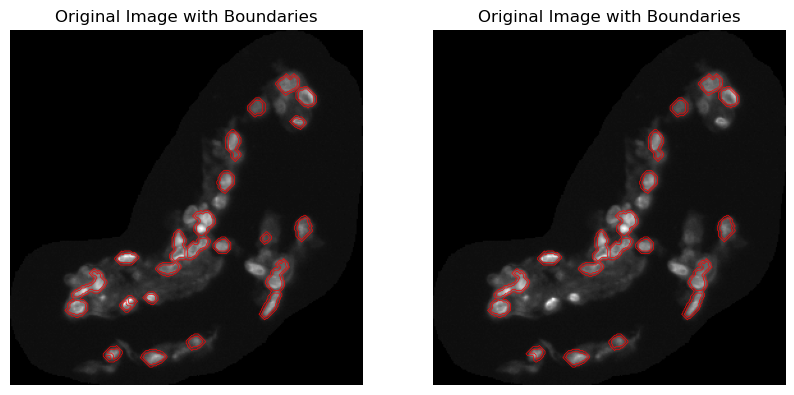

In [209]:
# Measure the area of each segmented region
areas = measure.regionprops(small_labels)

# Calculate the mean area of segmented regions
mean_area = np.mean([prop.area for prop in areas])

# Set a threshold based on the mean area, or any other criterion
threshold_area = mean_area * 0.5  # You can adjust the factor as needed

# Threshold based on segmented regions area
segmented_mask = np.zeros_like(smalldapi_open)
for prop in areas:
    if prop.area > threshold_area:
        segmented_mask[small_labels == prop.label] = 1

# Display segmentation over original image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(roi_smalldapi, cmap='gray')
plt.contour(small_boundaries, colors='r', linewidths=0.5)
plt.title('Original Image with Boundaries')
plt.axis('off')

# Print information
print("Mean area:", mean_area)
print("Threshold area:", threshold_area)

# Watershed again
distance = ndi.distance_transform_edt(segmented_mask)
coords = peak_local_max(distance, footprint=np.ones((32, 32)), labels=segmented_mask)
dist_mask = np.zeros(distance.shape, dtype=bool)
dist_mask[tuple(coords.T)] = True
markers, _ = ndi.label(dist_mask)

# Watershed segmentation
labels = watershed(-distance, markers, mask=segmented_mask)

# Find boundaries of watershed elements
boundaries = find_boundaries(labels)

# Display segmentation over original image
plt.subplot(1, 2, 2)
plt.imshow(roi_smalldapi, cmap='gray')
plt.contour(boundaries, colors='r', linewidths=0.5)
plt.title('Original Image with Boundaries')
plt.axis('off')
plt.show()

Extract satistic features

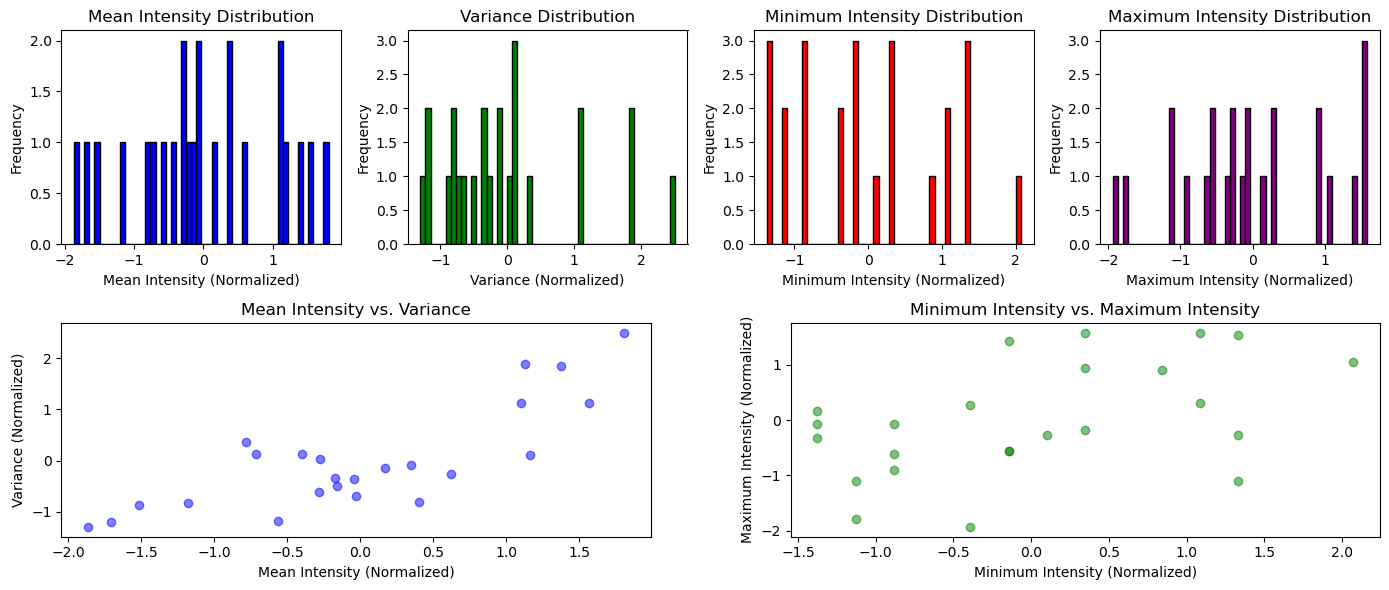

In [188]:
# Initialize lists to store feature values
mean_intensities = []
variances = []
min_intensities = []
max_intensities = []

# Iterate over each labeled region
for label in range(1, small_labels.max() + 1):  # Iterate over each label excluding background
    # Mask out the region in the original image
    region_mask = small_labels == label
    region_pixels = roi_smalldapi[region_mask]
    
    # Compute mean intensity of the region
    mean_intensity = np.mean(region_pixels)
    mean_intensities.append(mean_intensity)
    
    # Compute variance of intensity in the region
    variance = np.var(region_pixels)
    variances.append(variance)
    
    # Compute minimum intensity in the region
    min_intensity = np.min(region_pixels)
    min_intensities.append(min_intensity)
    
    # Compute maximum intensity in the region
    max_intensity = np.max(region_pixels)
    max_intensities.append(max_intensity)

# Z-score normalization
mean_intensities_normalized = (mean_intensities - np.mean(mean_intensities)) / np.std(mean_intensities)
variances_normalized = (variances - np.mean(variances)) / np.std(variances)
min_intensities_normalized = (min_intensities - np.mean(min_intensities)) / np.std(min_intensities)
max_intensities_normalized = (max_intensities - np.mean(max_intensities)) / np.std(max_intensities)

# Plot histograms of the extracted features
plt.figure(figsize=(14, 6))

plt.subplot(2, 4, 1)
plt.hist(mean_intensities_normalized, bins=50, color='blue', edgecolor='black')
plt.title('Mean Intensity Distribution')
plt.xlabel('Mean Intensity (Normalized)')
plt.ylabel('Frequency')

plt.subplot(2, 4, 2)
plt.hist(variances_normalized, bins=50, color='green', edgecolor='black')
plt.title('Variance Distribution')
plt.xlabel('Variance (Normalized)')
plt.ylabel('Frequency')

plt.subplot(2, 4, 3)
plt.hist(min_intensities_normalized, bins=50, color='red', edgecolor='black')
plt.title('Minimum Intensity Distribution')
plt.xlabel('Minimum Intensity (Normalized)')
plt.ylabel('Frequency')

plt.subplot(2, 4, 4)
plt.hist(max_intensities_normalized, bins=50, color='purple', edgecolor='black')
plt.title('Maximum Intensity Distribution')
plt.xlabel('Maximum Intensity (Normalized)')
plt.ylabel('Frequency')

# Plot scatter plots of pairs of features
plt.subplot(2, 2, 3)
plt.scatter(mean_intensities_normalized, variances_normalized, color='blue', alpha=0.5)
plt.title('Mean Intensity vs. Variance')
plt.xlabel('Mean Intensity (Normalized)')
plt.ylabel('Variance (Normalized)')

plt.subplot(2, 2, 4)
plt.scatter(min_intensities_normalized, max_intensities_normalized, color='green', alpha=0.5)
plt.title('Minimum Intensity vs. Maximum Intensity')
plt.xlabel('Minimum Intensity (Normalized)')
plt.ylabel('Maximum Intensity (Normalized)')

plt.tight_layout()
plt.show()

Kmeans clustering

d:\Anaconda\envs\eel5840\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\envs\eel5840\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


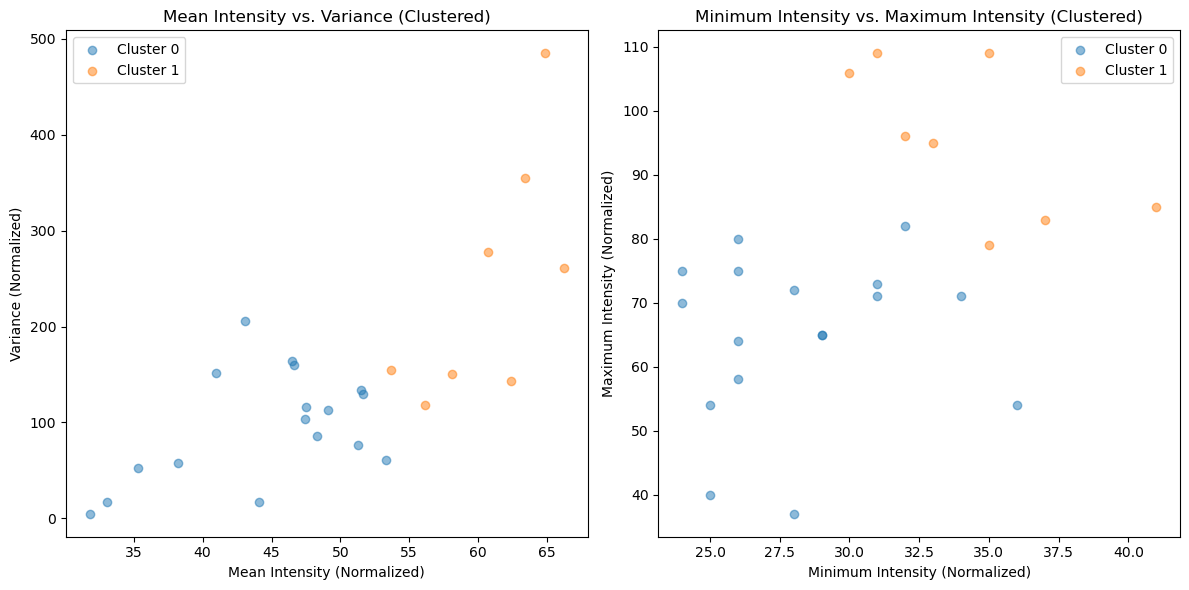

In [172]:
# Get region properties for each labeled region (nucleus)
props_small = regionprops(small_labels)

# Combine features into a feature matrix
feature_matrix = np.column_stack((mean_intensities_normalized, variances_normalized, min_intensities_normalized, max_intensities_normalized))

# Define the number of clusters
num_clusters = 2  # Adjust this according to your data

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(feature_matrix)

# Add cluster labels to props for visualization or further analysis
for i, region in enumerate(props_small):
    region.cluster_label = cluster_labels[i]

# Visualize the clusters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for cluster_label in range(num_clusters):
    cluster_mean_intensities = [mean_intensities[i] for i, label in enumerate(cluster_labels) if label == cluster_label]
    cluster_variances = [variances[i] for i, label in enumerate(cluster_labels) if label == cluster_label]
    plt.scatter(cluster_mean_intensities, cluster_variances, label=f'Cluster {cluster_label}', alpha=0.5)
plt.title('Mean Intensity vs. Variance (Clustered)')
plt.xlabel('Mean Intensity (Normalized)')
plt.ylabel('Variance (Normalized)')
plt.legend()

plt.subplot(1, 2, 2)
for cluster_label in range(num_clusters):
    cluster_min_intensities = [min_intensities[i] for i, label in enumerate(cluster_labels) if label == cluster_label]
    cluster_max_intensities = [max_intensities[i] for i, label in enumerate(cluster_labels) if label == cluster_label]
    plt.scatter(cluster_min_intensities, cluster_max_intensities, label=f'Cluster {cluster_label}', alpha=0.5)
plt.title('Minimum Intensity vs. Maximum Intensity (Clustered)')
plt.xlabel('Minimum Intensity (Normalized)')
plt.ylabel('Maximum Intensity (Normalized)')
plt.legend()

plt.tight_layout()
plt.show()

Overlay cluster result on histology image

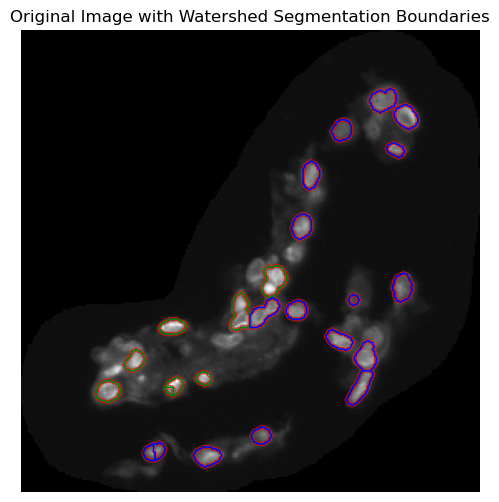

In [173]:
# Display the segmentation over the original image
plt.figure(figsize=(10, 6))

# Overlay the original image with the segmentation boundaries
plt.imshow(roi_smalldapi, cmap='gray')  # Assuming dapi is the original image
plt.contour(small_boundaries, colors='r', linewidths=0.5)
plt.title('Original Image with Watershed Segmentation Boundaries')
plt.axis('off')

# Define colors for each cluster label
cluster_colors = ['b', 'g', 'y', 'c', 'm']  # Add more colors if needed

# Overlay nuclei clusters with different colors on the original image
for region in props_small:
    cluster_label = region.cluster_label
    if cluster_label < len(cluster_colors):
        mask = small_labels == region.label
        plt.contour(mask, colors=cluster_colors[cluster_label], linewidths=1)

plt.show()

## Bigger cropped DAPI

Extract bigger image

In [174]:
def parse_json_features(json_data):
    nuclei_annotations = []
    for feature in json_data['features']:
        if feature['geometry']['type'] == 'Polygon':
            vertices = feature['geometry']['coordinates'][0]  # First ring
            vertices = [(int(coord[0]), int(coord[1])) for coord in vertices]  # Assuming (x, y) format
            nuclei_annotations.append(vertices)
    return nuclei_annotations

def create_ground_truth_mask(image_shape, nuclei_annotations):
    ground_truth_mask = np.zeros(image_shape, dtype=np.uint8)
    for annotation in nuclei_annotations:
        rr, cc = polygon([v[1] for v in annotation], [v[0] for v in annotation], image_shape)
        ground_truth_mask[rr, cc] = 1
    return ground_truth_mask

# Load GeoJSON file into pandas DataFrame
json_file = 'codex.geojson'
json_data = pd.read_json(json_file)

# Parse JSON features
nuclei_annotations = parse_json_features(json_data)

# Get the shape of the binary mask to create the ground truth mask
image_shape = dapi.shape

# Create ground truth mask
ground_truth_mask_json = create_ground_truth_mask(image_shape, nuclei_annotations)

# Display ground truth mask from JSON
# plt.imshow(ground_truth_mask_json, cmap='gray')
# plt.title('Ground Truth Mask from JSON')
# plt.axis('off')
# plt.show()

Calculate x&y coordinate

In [175]:
mask_dapi = ground_truth_mask_json * dapi # .squeeze()

# Find the indices where the mask value is 1
roi_indices = np.where(ground_truth_mask_json == 1)

# Get the minimum and maximum x and y coordinates
min_x = np.min(roi_indices[1])
max_x = np.max(roi_indices[1])
min_y = np.min(roi_indices[0])
max_y = np.max(roi_indices[0])

print(min_x, max_x, min_y, max_y)

7307 7998 15855 17361


Display cropped dapi

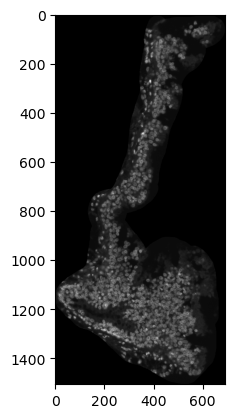

In [176]:
roi_dapi = mask_dapi[min_y:max_y,min_x:max_x]
plt.imshow(roi_dapi, 'gray')

Tophat processing

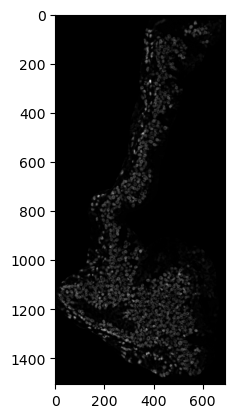

In [177]:
tophat_image = white_tophat(roi_dapi, footprint=np.ones((15, 15)))
plt.imshow(tophat_image,cmap='gray')

Otsu thresholding

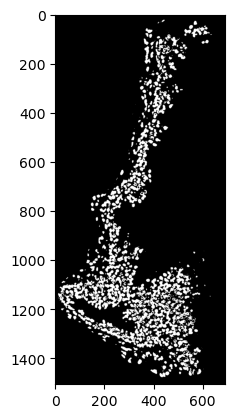

In [178]:
# Thresholding
thresh = filters.threshold_otsu(tophat_image)
dapi_binary = tophat_image > thresh
plt.imshow(dapi_binary,cmap='gray')

Morphological process

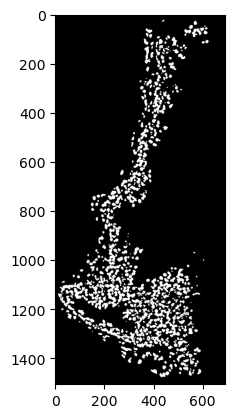

In [193]:
dapi_open = morphology.binary_opening(dapi_binary, morphology.disk(2))
plt.imshow(dapi_open,cmap='gray')

Watershed segmentation

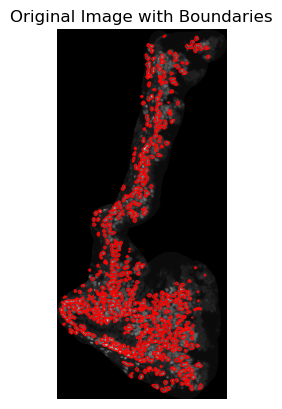

In [206]:
distance = ndi.distance_transform_edt(dapi_open)
coords = peak_local_max(distance, footprint=np.ones((32, 32)), labels=dapi_open)
dist_mask = np.zeros(distance.shape, dtype=bool)
dist_mask[tuple(coords.T)] = True
markers, _ = ndi.label(dist_mask)

# Watershed segmentation
labels = watershed(-distance, markers, mask=dapi_open)

# Find boundaries of watershed elements
boundaries = find_boundaries(labels)

# Display segmentation over original image
plt.imshow(roi_dapi, cmap='gray')
plt.contour(boundaries, colors='r', linewidths=0.5)
plt.title('Original Image with Boundaries')
plt.axis('off')
plt.show()

Mean area: 236.2841225626741
Threshold area: 118.14206128133705
Number of regions above threshold: 77703


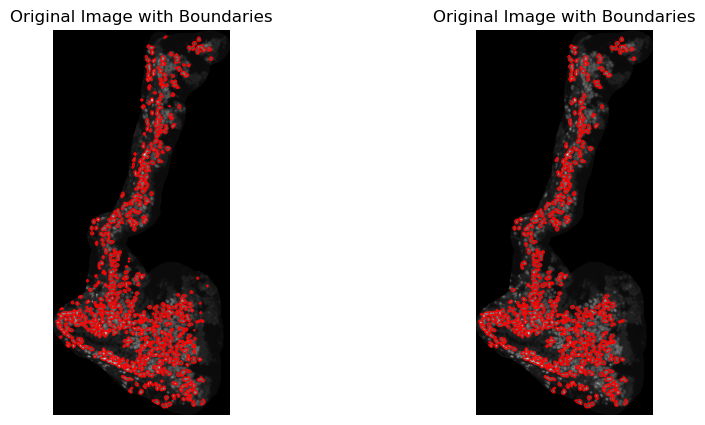

In [207]:
# Measure the area of each segmented region
areas = measure.regionprops(labels)

# Calculate the mean area of segmented regions
mean_area = np.mean([prop.area for prop in areas])

# Set a threshold based on the mean area, or any other criterion
threshold_area = mean_area * 0.5  # You can adjust the factor as needed

# Threshold based on segmented regions area
segmented_mask = np.zeros_like(dapi_open)
for prop in areas:
    if prop.area > threshold_area:
        segmented_mask[labels == prop.label] = 1

# Display segmentation over original image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(roi_dapi, cmap='gray')
plt.contour(boundaries, colors='r', linewidths=0.5)
plt.title('Original Image with Boundaries')
plt.axis('off')

# Print information
print("Mean area:", mean_area)
print("Threshold area:", threshold_area)

# Watershed again
distance = ndi.distance_transform_edt(segmented_mask)
coords = peak_local_max(distance, footprint=np.ones((32, 32)), labels=segmented_mask)
dist_mask = np.zeros(distance.shape, dtype=bool)
dist_mask[tuple(coords.T)] = True
markers, _ = ndi.label(dist_mask)

# Watershed segmentation
labels = watershed(-distance, markers, mask=segmented_mask)

# Find boundaries of watershed elements
boundaries = find_boundaries(labels)

# Display segmentation over original image
plt.subplot(1, 2, 2)
plt.imshow(roi_dapi, cmap='gray')
plt.contour(boundaries, colors='r', linewidths=0.5)
plt.title('Original Image with Boundaries')
plt.axis('off')
plt.show()

Overlay cluster result on histology image

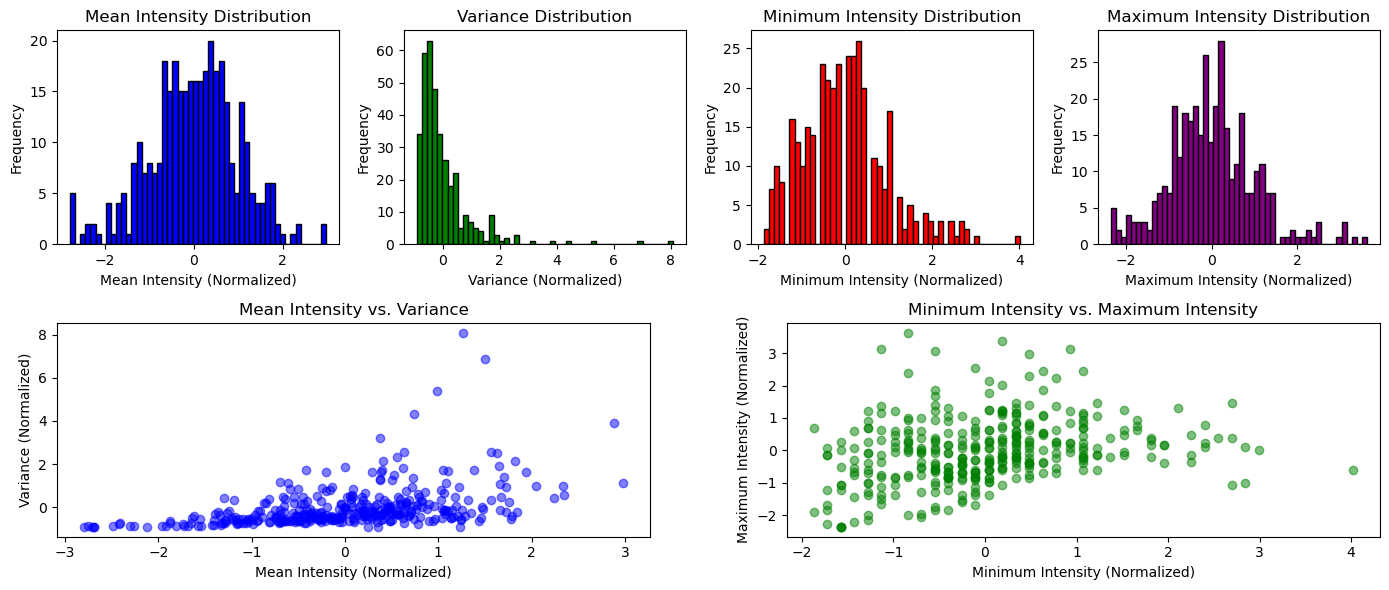

In [191]:
# Initialize lists to store feature values
mean_intensities = []
variances = []
min_intensities = []
max_intensities = []

# Iterate over each labeled region
for label in range(1, labels.max() + 1):  # Iterate over each label excluding background
    # Mask out the region in the original image
    region_mask = labels == label
    region_pixels = roi_dapi[region_mask]
    
    # Compute mean intensity of the region
    mean_intensity = np.mean(region_pixels)
    mean_intensities.append(mean_intensity)
    
    # Compute variance of intensity in the region
    variance = np.var(region_pixels)
    variances.append(variance)
    
    # Compute minimum intensity in the region
    min_intensity = np.min(region_pixels)
    min_intensities.append(min_intensity)
    
    # Compute maximum intensity in the region
    max_intensity = np.max(region_pixels)
    max_intensities.append(max_intensity)

# Z-score normalization
mean_intensities_normalized = (mean_intensities - np.mean(mean_intensities)) / np.std(mean_intensities)
variances_normalized = (variances - np.mean(variances)) / np.std(variances)
min_intensities_normalized = (min_intensities - np.mean(min_intensities)) / np.std(min_intensities)
max_intensities_normalized = (max_intensities - np.mean(max_intensities)) / np.std(max_intensities)

# Plot histograms of the extracted features
plt.figure(figsize=(14, 6))

plt.subplot(2, 4, 1)
plt.hist(mean_intensities_normalized, bins=50, color='blue', edgecolor='black')
plt.title('Mean Intensity Distribution')
plt.xlabel('Mean Intensity (Normalized)')
plt.ylabel('Frequency')

plt.subplot(2, 4, 2)
plt.hist(variances_normalized, bins=50, color='green', edgecolor='black')
plt.title('Variance Distribution')
plt.xlabel('Variance (Normalized)')
plt.ylabel('Frequency')

plt.subplot(2, 4, 3)
plt.hist(min_intensities_normalized, bins=50, color='red', edgecolor='black')
plt.title('Minimum Intensity Distribution')
plt.xlabel('Minimum Intensity (Normalized)')
plt.ylabel('Frequency')

plt.subplot(2, 4, 4)
plt.hist(max_intensities_normalized, bins=50, color='purple', edgecolor='black')
plt.title('Maximum Intensity Distribution')
plt.xlabel('Maximum Intensity (Normalized)')
plt.ylabel('Frequency')

# Plot scatter plots of pairs of features
plt.subplot(2, 2, 3)
plt.scatter(mean_intensities_normalized, variances_normalized, color='blue', alpha=0.5)
plt.title('Mean Intensity vs. Variance')
plt.xlabel('Mean Intensity (Normalized)')
plt.ylabel('Variance (Normalized)')

plt.subplot(2, 2, 4)
plt.scatter(min_intensities_normalized, max_intensities_normalized, color='green', alpha=0.5)
plt.title('Minimum Intensity vs. Maximum Intensity')
plt.xlabel('Minimum Intensity (Normalized)')
plt.ylabel('Maximum Intensity (Normalized)')

plt.tight_layout()
plt.show()


d:\Anaconda\envs\eel5840\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\envs\eel5840\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


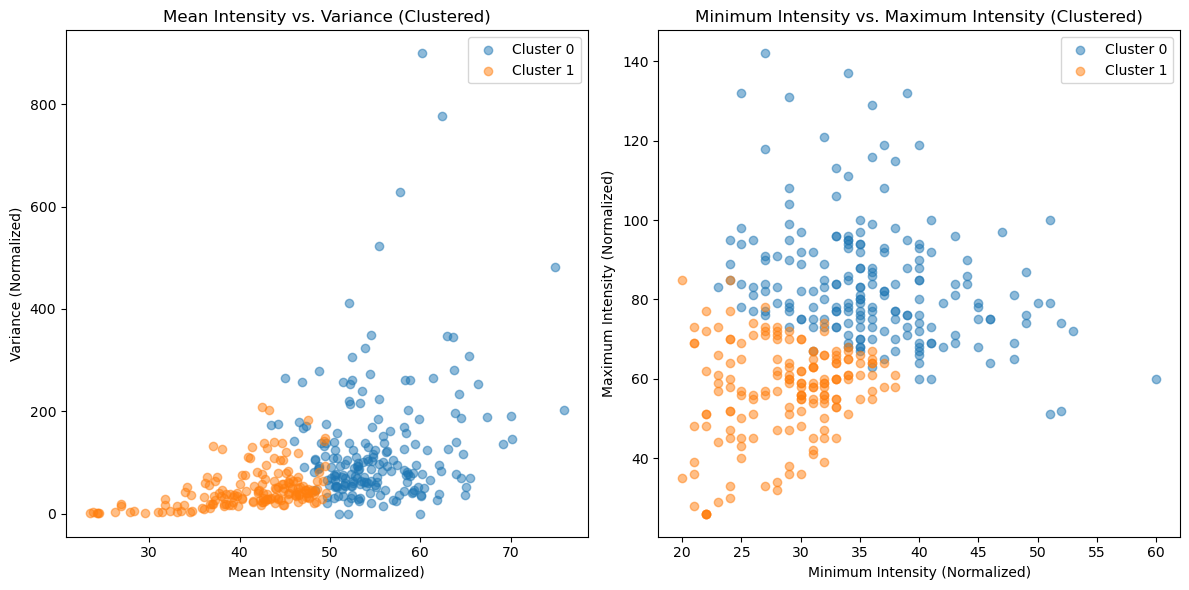

In [192]:
# Get region properties for each labeled region (nucleus)
props = regionprops(labels)

# Combine features into a feature matrix
feature_matrix = np.column_stack((mean_intensities_normalized, variances_normalized, min_intensities_normalized, max_intensities_normalized))

# Define the number of clusters
num_clusters = 2 # Adjust this according to your data

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(feature_matrix)

# Add cluster labels to props for visualization or further analysis
for i, region in enumerate(props):
    region.cluster_label = cluster_labels[i]

# Visualize the clusters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for cluster_label in range(num_clusters):
    cluster_mean_intensities = [mean_intensities[i] for i, label in enumerate(cluster_labels) if label == cluster_label]
    cluster_variances = [variances[i] for i, label in enumerate(cluster_labels) if label == cluster_label]
    plt.scatter(cluster_mean_intensities, cluster_variances, label=f'Cluster {cluster_label}', alpha=0.5)
plt.title('Mean Intensity vs. Variance (Clustered)')
plt.xlabel('Mean Intensity (Normalized)')
plt.ylabel('Variance (Normalized)')
plt.legend()

plt.subplot(1, 2, 2)
for cluster_label in range(num_clusters):
    cluster_min_intensities = [min_intensities[i] for i, label in enumerate(cluster_labels) if label == cluster_label]
    cluster_max_intensities = [max_intensities[i] for i, label in enumerate(cluster_labels) if label == cluster_label]
    plt.scatter(cluster_min_intensities, cluster_max_intensities, label=f'Cluster {cluster_label}', alpha=0.5)
plt.title('Minimum Intensity vs. Maximum Intensity (Clustered)')
plt.xlabel('Minimum Intensity (Normalized)')
plt.ylabel('Maximum Intensity (Normalized)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Display the segmentation over the original image
plt.figure(figsize=(10, 6))

# Overlay the original image with the segmentation boundaries
plt.imshow(dapi, cmap='gray')  # Assuming dapi is the original image
plt.contour(boundaries, colors='r', linewidths=0.5)
plt.title('Original Image with Watershed Segmentation Boundaries')
plt.axis('off')

# Define colors for each cluster label
cluster_colors = ['b', 'g', 'y', 'c', 'm']  # Add more colors if needed

# Overlay nuclei clusters with different colors on the original image
for region in props:
    cluster_label = region.cluster_label
    if cluster_label < len(cluster_colors):
        mask = labels == region.label
        plt.contour(mask, colors=cluster_colors[cluster_label], linewidths=1)

plt.show()

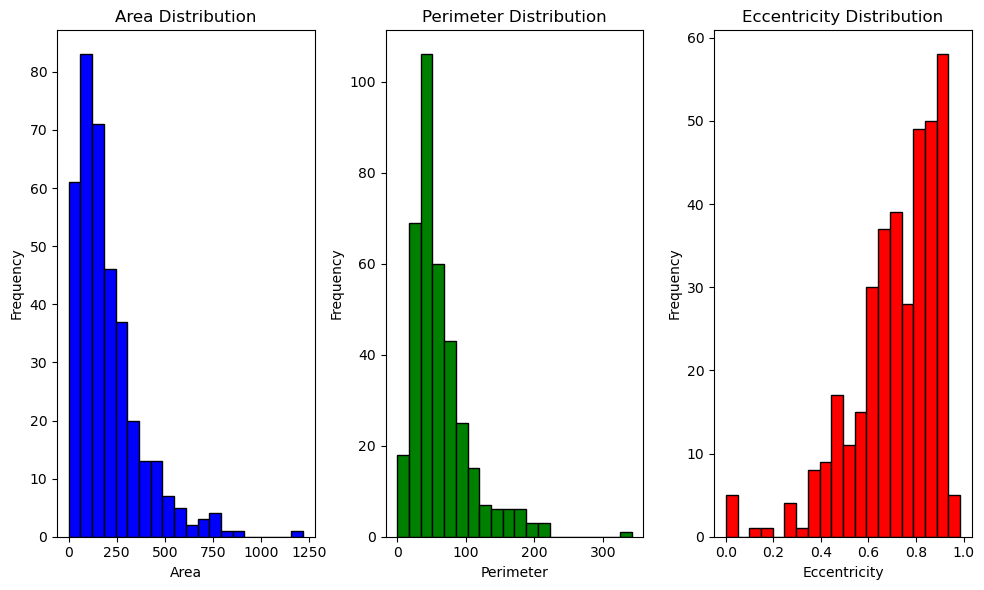

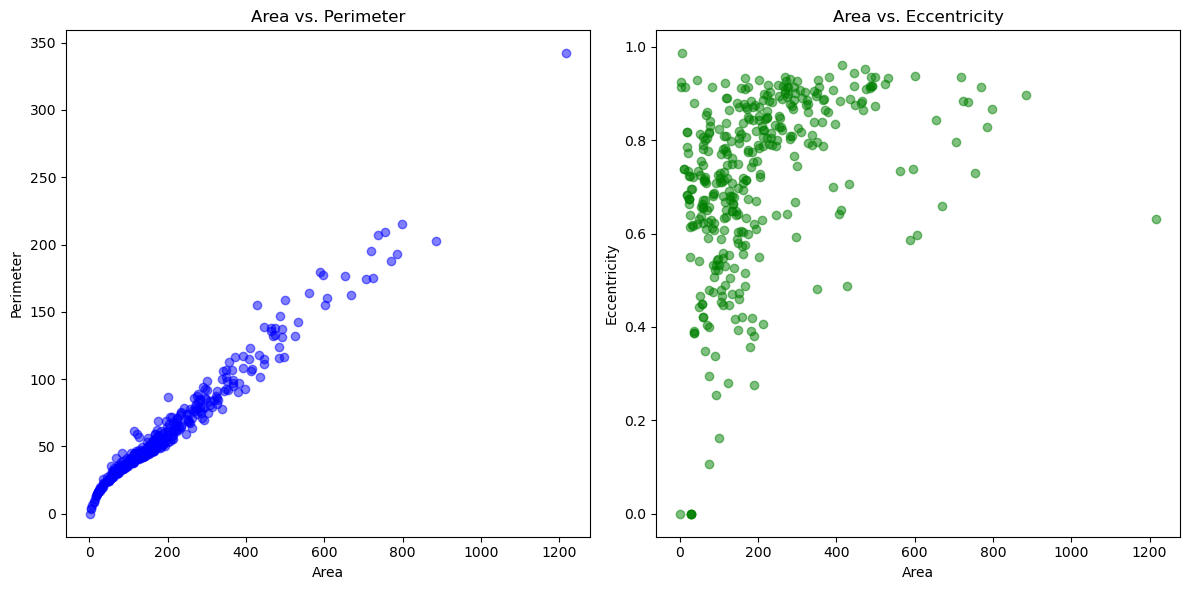

In [184]:
# Get region properties for each labeled region (nucleus)
props = regionprops(labels)

# Initialize lists to store feature values
areas = []
perimeters = []
eccentricities = []
# Add more lists for additional features as needed

# Iterate over each labeled region
for region in props:
    # Compute area of the region
    area = region.area
    areas.append(area)
    
    # Compute perimeter of the region
    perimeter = region.perimeter
    perimeters.append(perimeter)
    
    # Compute eccentricity of the region
    eccentricity = region.eccentricity
    eccentricities.append(eccentricity)

# Plot histograms of the extracted features
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.hist(areas, bins=20, color='blue', edgecolor='black')
plt.title('Area Distribution')
plt.xlabel('Area')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(perimeters, bins=20, color='green', edgecolor='black')
plt.title('Perimeter Distribution')
plt.xlabel('Perimeter')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(eccentricities, bins=20, color='red', edgecolor='black')
plt.title('Eccentricity Distribution')
plt.xlabel('Eccentricity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot scatter plots of pairs of features
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(areas, perimeters, color='blue', alpha=0.5)
plt.title('Area vs. Perimeter')
plt.xlabel('Area')
plt.ylabel('Perimeter')

plt.subplot(1, 2, 2)
plt.scatter(areas, eccentricities, color='green', alpha=0.5)
plt.title('Area vs. Eccentricity')
plt.xlabel('Area')
plt.ylabel('Eccentricity')

plt.tight_layout()
plt.show()
    

d:\Anaconda\envs\eel5840\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\envs\eel5840\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


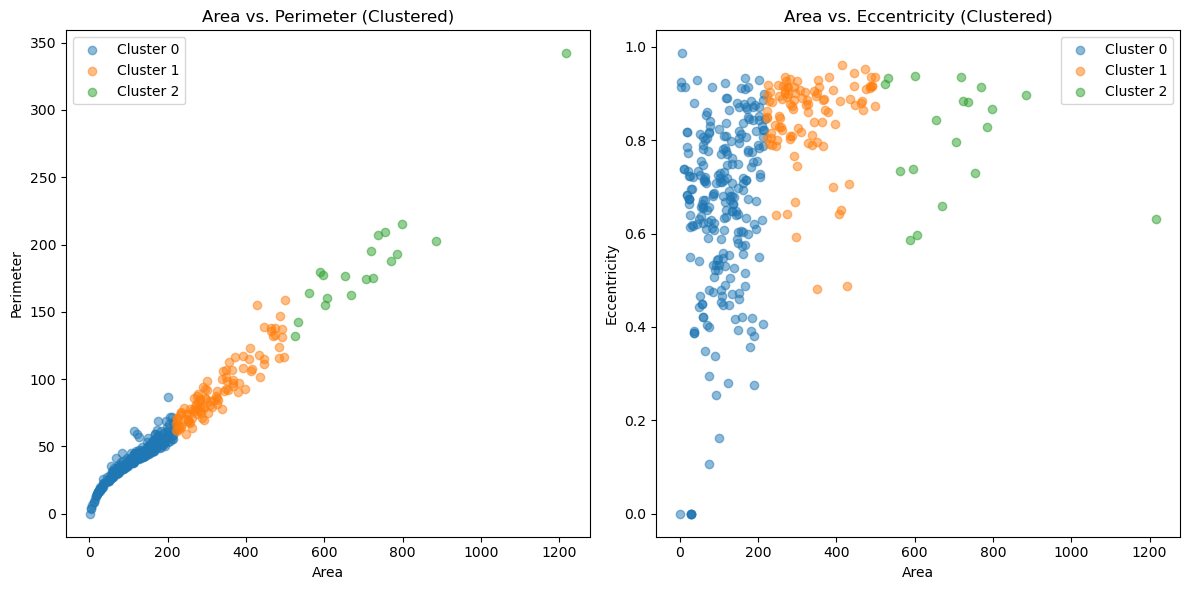

In [185]:
# Combine features into a feature matrix
feature_matrix = np.column_stack((areas, perimeters, eccentricities))

# Define the number of clusters
num_clusters = 3  # Adjust this according to your data

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(feature_matrix)

# Add cluster labels to props for visualization or further analysis
for i, region in enumerate(props):
    region.cluster_label = cluster_labels[i]

# Visualize the clusters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for cluster_label in range(num_clusters):
    cluster_areas = [props[i].area for i, label in enumerate(cluster_labels) if label == cluster_label]
    cluster_perimeters = [props[i].perimeter for i, label in enumerate(cluster_labels) if label == cluster_label]
    plt.scatter(cluster_areas, cluster_perimeters, label=f'Cluster {cluster_label}', alpha=0.5)
plt.title('Area vs. Perimeter (Clustered)')
plt.xlabel('Area')
plt.ylabel('Perimeter')
plt.legend()

plt.subplot(1, 2, 2)
for cluster_label in range(num_clusters):
    cluster_areas = [props[i].area for i, label in enumerate(cluster_labels) if label == cluster_label]
    cluster_eccentricities = [props[i].eccentricity for i, label in enumerate(cluster_labels) if label == cluster_label]
    plt.scatter(cluster_areas, cluster_eccentricities, label=f'Cluster {cluster_label}', alpha=0.5)
plt.title('Area vs. Eccentricity (Clustered)')
plt.xlabel('Area')
plt.ylabel('Eccentricity')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Display the segmentation over the original image
plt.figure(figsize=(10, 6))

# Overlay the original image with the segmentation boundaries
plt.imshow(dapi, cmap='gray') # cropped_dapi, cmap='gray'
plt.contour(boundaries, colors='r', linewidths=0.5)
plt.title('Original Image with Watershed Segmentation Boundaries')
plt.axis('off')

# Initialize a colormap for clustering
cluster_colors = ['b', 'g', 'y', 'c', 'm']  # Add more colors if needed

# Iterate over each labeled region and plot its cluster in a different color
for region in props:
    cluster_label = region.cluster_label
    if cluster_label < len(cluster_colors):
        # Overlay nuclei clusters with different colors on the original image
        mask = labels == region.label
        plt.contour(mask, colors=cluster_colors[cluster_label], linewidths=1)

plt.show()

fix size gabor filter generate glom mask
heat map

import wsi_annotations_kit.wsi_annotations_kit as wak

annotations = wak.Annotation()
# Find the mask

annotations.add_mask(
mask,
crs,
structures,
)

annotations.write_xml('filepath")